In [1]:
import dicom
import inspect
import pylab
import numpy as np
from glob import glob
import os

import matplotlib
import matplotlib.pyplot as plt

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

from ml_utils import *
import math
from sys import stdout

/usr/local/lib/python3.5/dist-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)
Using TensorFlow backend.


In [2]:
benigns = np.load('benign_cropped.npy')
maligs = np.load('malig_cropped.npy')
nroi = np.load('nroi.npy')

In [3]:
benigns = preprocess(np.array(list(map(getFromSlice('roi'), flatten(benigns)))))
maligs = preprocess(np.array(list(map(getFromSlice('roi'), flatten(maligs)))))
nroi = preprocess(np.array(list(map(getFromSlice('nroi'), flatten(nroi)))))

In [4]:
np.random.shuffle(benigns)
np.random.shuffle(maligs)
np.random.shuffle(nroi)

In [5]:
nb = benigns.shape[0] // 3
nm = maligs.shape[0] // 3
nn = nroi.shape[0] // 3
b_t = benigns[:-nb]
b_v = benigns[-nb:]
m_t = maligs[:-nm]
m_v = maligs[-nm:]
n_t = nroi[:-nn]
n_v = nroi[-nn:]

In [6]:
data_gen = symmetric_data_generator([b_t, m_t, n_t],[np.array([0,1,0]),np.array([0,0,1]),np.array([1,0,0])], 96)

In [7]:
X, y = next(data_gen)

In [8]:
print(X.shape, y.shape)

(96, 80, 80, 1) (96, 3)


In [9]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(80, 80, 1)))
model.add(Activation('relu'))
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(Convolution2D(128, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Dense(3))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['precision', 'recall'])

In [10]:
imgGen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True)

In [11]:
val_feeder = symmetric_data_generator([b_v, m_v, n_v], [np.array([0,1,0]),np.array([0,0,1]),np.array([1,0,0])], 192)

def evaluate(model):
    X, y = next(val_feeder)
    res = model.evaluate(X, y)
    print ('validation loss: %f\t prec: %f\trecall: %f' % tuple(res))

In [19]:
nb_epoch = 3
nb_batch = 3

for e in range(nb_epoch):
    print ('Epoch %d' % e)
    for i in range(nb_batch):
        xx, yy = next(data_gen)
        X, y = next(imgGen.flow(xx, yy, batch_size=96))
        loss = model.train_on_batch(X, y)
        stdout.write('\rbatch - %d ## train loss: %f\t prec: %f\t recall: %f' % tuple([i] + loss))
    evaluate(model)

Epoch 0
192/192 [==============================] - 0s      recall: 1.000000
validation loss: 0.258577	 prec: 0.901159	recall: 0.901042
Epoch 1
192/192 [==============================] - 0s      recall: 0.989583
validation loss: 0.395559	 prec: 0.856183	recall: 0.843750
Epoch 2
192/192 [==============================] - 0s      recall: 0.989583

In [24]:
evaluate(model)

192/192 [==============================] - 1s     
validation loss: 0.361337	 prec: 0.928819	recall: 0.911458


In [25]:
model.save('model-babystep3-control-triple-binary-classification.h5')

In [75]:
benigns = np.load('benign_cropped.npy')

stats = []
for b in benigns:
    res = model.predict_classes(preprocess(np.array(list(map(lambda slice: slice['roi'], b)))))
    stats.append(res)

4/4 [==============================] - 0s


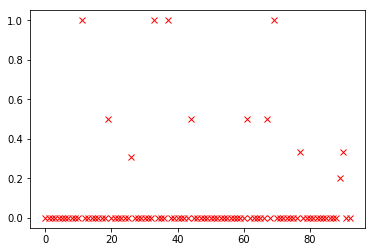

In [76]:
sss = [s.sum() / len(s) for s in stats]

plt.plot(sss, 'rx')
plt.show()

In [73]:
maligs = np.load('malig_cropped.npy')

stats = []
for m in maligs:
    res = model.predict_classes(preprocess(np.array(list(map(lambda slice: slice['roi'], m)))))
    stats.append(res)

4/4 [==============================] - 0s


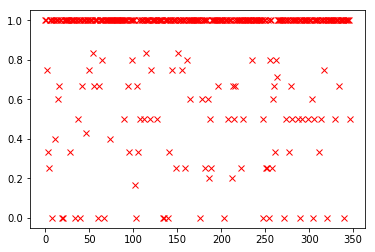

In [74]:
mmm = [s.sum() / len(s) for s in stats]

plt.plot(mmm, 'rx')
plt.show()

In [72]:
def preprocess(X):
    num = X.shape[0]
    X = X ** 0.5
    X = (X - np.max(X) / 2) / np.max(X)
    X = X.reshape(num, 80, 80, 1)
    return X

In [182]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=-1
)

gen = datagen.flow(X, y, batch_size=128)

In [ ]:
xx, yy = next(gen)
model.evaluate(xx, yy)

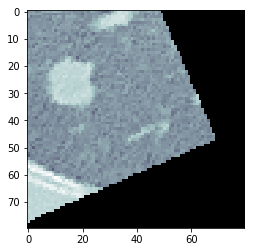

In [177]:
xx, yy = next(gen)
plt.imshow(xx[0].reshape(80,80), plt.cm.bone)
plt.show()

In [14]:
model

In [36]:
evaluate(model)

192/192 [==============================] - 0s     
validation loss: 1.286353	 prec: 0.869792	recall: 0.869792


In [37]:
model.save('model-babystep2-ternary-classification.h5')

In [9]:
np.tile(np.array([1,2,3]), (1,3))

array([[1, 2, 3, 1, 2, 3, 1, 2, 3]])